In [1]:
import pandas as pd
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import warnings
from sklearn.preprocessing import StandardScaler
import logging
import numpy as np
import networkx as nx
from torch.autograd import Function


warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
class DCFOD(nn.Module):
    """
    DCFOD consists of a encoder, decoder, discriminator, and cluster centroid layer
    """

    def __init__(self, input_size, num_classes, num_features, num_attributes, cuda):
        super(DCFOD, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.num_features = num_features
        self.num_attributes = num_attributes
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(input_size, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, num_features)
        ).to(cuda)

        self.discriminator = nn.Sequential(
            nn.Linear(num_features, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, num_attributes)
        ).to(cuda)

        self.decoder = nn.Sequential(
            nn.Linear(num_features, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, input_size)
        ).to(cuda)

        self.clusterCenter = nn.Parameter(torch.zeros(num_classes, num_features).to(cuda))

        self.alpha = 1.0
        self.clusteringMode = False
        self.validateMode = False

        # -----model initialization----- #
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight).to(cuda)

    def setClusteringMode(self, mode):
        self.clusteringMode = mode

    def setValidateMode(self, mode):
        self.validateMode = mode

    def getDistanceToClusters(self, x):
        """
        obtain the distance to cluster centroids for each instance
        Args:
            x: sample on the embedded space
        Returns: square of the euclidean distance, and the euclidean distance
        """
        xe = torch.unsqueeze(x, 1) - self.clusterCenter
        dist_to_centers = torch.sum(torch.mul(xe, xe), 2)
        euclidean_dist = torch.sqrt(dist_to_centers)

        return dist_to_centers, euclidean_dist

    def forward(self, x):
        # -----feature embedding----- #
        x = x.view(-1, self.input_size)
        x_e = self.encoder(x)

        # -----if only wants to initialize cluster centroids
        # or validate the performance on the whole dataset, return x_e----- #
        if self.clusteringMode or self.validateMode:
            return x_e

        # -----else the discriminator predicts the subgroup assignment for each instance----- #
        reversed_x_e = GradientReversalLayer.apply(x_e)
        x_sa = self.discriminator(reversed_x_e)

        # -----if in training, return the embedded x, decoded x, and subgroup discrimination----- #
        x_de = self.decoder(x_e)
        x_de = x_de.view(-1, 1, self.input_size)

        return x_e, x_de, x_sa


class GradientReversalLayer(Function):

    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg(), None

In [3]:
gpu = '1'
if gpu == '0':
    cuda = torch.device('cuda:0')
    devices = [0, 1, 2, 3]
elif gpu == '1':
    cuda = torch.device('cuda:1')
    devices = [1, 2, 3, 0]
elif gpu == '2':
    cuda = torch.device('cuda:2')
    devices = [2, 3, 0, 1]
elif gpu == '3':
    cuda = torch.device('cuda:3')
    devices = [3, 0, 1, 2]
else:
    raise NameError('no more GPUs')

In [4]:
def set_seed(seed):
    print(f"setting seed to {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.use_deterministic_algorithms(True)
    # torch.backends.cudnn.benchmark = False

In [5]:
import random
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score, f1_score


def set_seed(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def get_samples(dataset, upper=None, lower=None):
    df_X = pd.DataFrame(dataset.X.reshape(-1, 20))
    df_X['y'] = dataset.y
    df_X_cf = pd.DataFrame(dataset.X_cf.reshape(-1, 20))
    df_X_cf['y'] = dataset.y_cf
    # lst_y = df_X['y'].values
    lst_y = np.array(np.concatenate((df_X['y'].values, df_X_cf['y'].values)))
    if (upper is None) or (lower is None):
        ab_upper = np.quantile(lst_y, 0.99)
        ab_cf_uupper = np.quantile(lst_y, 0.90)
        ab_cf_ulower = np.quantile(lst_y, 0.85)
        # ab_cf_lupper = np.quantile(lst_y, 0.05)
        # ab_cf_llower = np.quantile(lst_y, 0.04)
        n_cf_upper = np.quantile(lst_y, 0.7)
        n_cf_lower = np.quantile(lst_y, 0.68)
        ab_lower = np.quantile(lst_y, 0.01)
        n_lower = np.quantile(lst_y, 0.3)
        n_upper = np.quantile(lst_y, 0.4)
    lst_n_c, lst_n_nc, lst_n_m, lst_ab_c, lst_ab_nc, lst_ab_m = [], [], [], [], [], []
    lst_n_c_cf, lst_n_nc_cf, lst_n_m_cf, lst_ab_c_cf, lst_ab_nc_cf, lst_ab_m_cf = [], [], [], [], [], []

    df_n = df_X.loc[(df_X['y'] > n_lower) & (df_X['y'] < n_upper)]
    df_n_cf = df_X_cf.loc[df_n.index]

    # df_n_c_cf = df_n_cf.loc[((df_n_cf['y'] > ab_cf_ulower) & (df_n_cf['y'] < ab_cf_uupper)) | ((df_n_cf['y'] > ab_cf_llower) & (df_n_cf['y'] < ab_cf_lupper))]
    df_n_c_cf = df_n_cf.loc[(df_n_cf['y'] > ab_cf_ulower) & (df_n_cf['y'] < ab_cf_uupper)]
    df_n_c = df_n.loc[df_n_c_cf.index]
    lst_n_c.extend(df_n_c.values)
    lst_n_c_cf.extend(df_n_c_cf.values)

    df_n_nc_cf = df_n_cf.loc[(df_n_cf['y'] > n_lower) & (df_n_cf['y'] < n_upper)]
    df_n_nc = df_n.loc[df_n_nc_cf.index]
    lst_n_nc.extend(df_n_nc.values)
    lst_n_nc_cf.extend(df_n_nc_cf.values)

    df_ab = df_X.loc[(df_X['y'] < ab_lower) | (df_X['y'] > ab_upper)]
    df_ab_cf = df_X_cf.loc[df_ab.index]

    df_ab_nc_cf = df_ab_cf.loc[(df_ab_cf['y'] < ab_lower) | (df_ab_cf['y'] > ab_upper)]
    df_ab_nc = df_ab.loc[df_ab_nc_cf.index]
    lst_ab_nc.extend(df_ab_nc.values)
    lst_ab_nc_cf.extend(df_ab_nc_cf.values)

    df_ab_c_cf = df_ab_cf.loc[(df_ab_cf['y'] > n_cf_lower) & (df_ab_cf['y'] < n_cf_upper)]
    df_ab_c = df_ab.loc[df_ab_c_cf.index]
    lst_ab_c.extend(df_ab_c.values)
    lst_ab_c_cf.extend(df_ab_c_cf.values)

    lst_temp = lst_n_c.copy()
    lst_temp.extend(lst_n_nc)
    #     lst_temp.extend(lst_n_m)
    lst_changed = [1 for _ in range(len(lst_n_c))]
    lst_changed.extend([0 for _ in range(len(lst_n_nc))])
    #     lst_changed.extend([-1 for _ in range(len(lst_n_m))])
    df_n = pd.DataFrame(lst_temp)
    df_n['changed'] = lst_changed
    df_n['label'] = 0
    df_n = df_n.sample(n=len(df_n), random_state=42)

    lst_temp = lst_ab_c.copy()
    lst_temp.extend(lst_ab_nc)
    #     lst_temp.extend(lst_ab_m)
    lst_changed = [1 for _ in range(len(lst_ab_c))]
    lst_changed.extend([0 for _ in range(len(lst_ab_nc))])
    #     lst_changed.extend([-1 for _ in range(len(lst_ab_m))])
    df_ab = pd.DataFrame(lst_temp)
    df_ab['changed'] = lst_changed
    df_ab['label'] = 1

    lst_temp = lst_n_c_cf.copy()
    lst_temp.extend(lst_n_nc_cf)
    #     lst_temp.extend(lst_n_m_cf)
    lst_changed = [1 for _ in range(len(lst_n_c_cf))]
    lst_changed.extend([0 for _ in range(len(lst_n_nc_cf))])
    #     lst_changed.extend([-1 for _ in range(len(lst_n_m_cf))])
    lst_label = [1 for _ in range(len(lst_n_c_cf))]
    lst_label.extend([0 for _ in range(len(lst_n_nc_cf))])
    #     lst_label.extend([0 for _ in range(len(lst_n_m_cf))])
    df_n_cf = pd.DataFrame(lst_temp)
    df_n_cf['changed'] = lst_changed
    df_n_cf['label'] = lst_label
    df_n_cf = df_n_cf.loc[df_n.index]

    lst_temp = lst_ab_c_cf.copy()
    lst_temp.extend(lst_ab_nc_cf)
    #     lst_temp.extend(lst_ab_m_cf)
    lst_changed = [1 for _ in range(len(lst_ab_c_cf))]
    lst_changed.extend([0 for _ in range(len(lst_ab_nc_cf))])
    #     lst_changed.extend([-1 for _ in range(len(lst_ab_m_cf))])
    lst_label = [0 for _ in range(len(lst_ab_c_cf))]
    lst_label.extend([1 for _ in range(len(lst_ab_nc_cf))])
    #     lst_label.extend([0 for _ in range(len(lst_ab_m_cf))])
    df_ab_cf = pd.DataFrame(lst_temp)
    df_ab_cf['changed'] = lst_changed
    df_ab_cf['label'] = lst_label

    major = len(df_n.loc[df_n[0] == 1])
    minor = int(major * 0.1)
    df_n_nc_major = df_n.loc[(df_n[0] == 1) & (df_n['changed'] == 0)]
    df_n_c_major = df_n.loc[(df_n[0] == 1) & (df_n['changed'] == 1)]
    #     df_n_m_major = df_n.loc[(df_n[0]==1) & (df_n['changed']==-1)]
    df_n_nc_minor = df_n.loc[(df_n[0] == -1) & (df_n['changed'] == 0)]
    df_n_c_minor = df_n.loc[(df_n[0] == -1) & (df_n['changed'] == 1)]
    #     df_n_m_minor = df_n.loc[(df_n[0]==-1) & (df_n['changed']==-1)]
    print(f"Normal major nc:{len(df_n_nc_major)}, c:{len(df_n_c_major)}")
    print(f"Normal minor nc:{len(df_n_nc_minor)}, c:{len(df_n_c_minor)}")

    df_ab_nc_major = df_ab.loc[(df_ab[0] == 1) & (df_ab['changed'] == 0)]
    df_ab_c_major = df_ab.loc[(df_ab[0] == 1) & (df_ab['changed'] == 1)]
    #     df_ab_m_major = df_ab.loc[(df_ab[0]==1) & (df_ab['changed']==-1)]
    df_ab_nc_minor = df_ab.loc[(df_ab[0] == -1) & (df_ab['changed'] == 0)]
    df_ab_c_minor = df_ab.loc[(df_ab[0] == -1) & (df_ab['changed'] == 1)]
    #     df_ab_m_minor = df_ab.loc[(df_ab[0]==-1) & (df_ab['changed']==-1)]
    print(f"Abnormal major nc:{len(df_ab_nc_major)}, c:{len(df_ab_c_major)}")
    print(f"Abnormal minor nc:{len(df_ab_nc_minor)}, c:{len(df_ab_c_minor)}")

    n_train = 3000
    df_train = pd.concat([df_n_nc_major.iloc[:n_train], df_n_c_major.iloc[:n_train], \
                          df_n_nc_minor.iloc[:n_train], df_n_c_minor.iloc[:n_train]])
    df_train = df_train.sample(n=len(df_train), random_state=42)
    df_eval_set = pd.concat([df_n_nc_major.iloc[0:1], df_n_c_major.iloc[0:1], \
                             df_n_nc_minor.iloc[0:1], df_n_c_minor.iloc[0:1]])
    df_test_n = pd.concat([df_n_nc_major.iloc[n_train:n_train+1000], df_n_c_major.iloc[n_train:n_train+1000], \
                           df_n_nc_minor.iloc[n_train:n_train+1000], df_n_c_minor.iloc[n_train:n_train+1000]])
    df_test_ab = pd.concat([df_ab_nc_major.iloc[:100], df_ab_c_major.iloc[:100], \
                            df_ab_nc_minor.iloc[:100], df_ab_c_minor.iloc[:100]])

    df_train_cf = df_n_cf.loc[df_train.index]
    df_eval_set_cf = df_n_cf.loc[df_eval_set.index]
    df_test_n_cf = df_n_cf.loc[df_test_n.index]
    df_test_ab_cf = df_ab_cf.loc[df_test_ab.index]

    df_eval = df_train.iloc[-1000:].reset_index(drop=True)
    df_train = df_train.iloc[:-1000].reset_index(drop=True)
    df_eval_set.reset_index(drop=True, inplace=True)
    df_test = pd.concat([df_test_n, df_test_ab]).reset_index(drop=True)

    df_eval_cf = df_train_cf.iloc[-1000:].reset_index(drop=True)
    df_train_cf = df_train_cf.iloc[:-1000].reset_index(drop=True)
    df_eval_set_cf.reset_index(drop=True, inplace=True)
    df_test_cf = pd.concat([df_test_n_cf, df_test_ab_cf]).reset_index(drop=True)

    return df_train, df_eval, df_test, df_eval_set, df_train_cf, df_eval_cf, df_test_cf, df_eval_set_cf





class CFDataset(Dataset):
    def __init__(self, X, do):
        self.X = X
        self.do = do

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.X[idx], self.do[idx])


def pretrain_split(df_train, df_eval):
    train_X = df_train.iloc[:, 1:-3].values.astype(np.float32)
    lst_temp = [1 for _ in range(len(train_X))]

    train_iter = DataLoader(CFDataset(torch.tensor(train_X.astype(np.float32)), torch.LongTensor(lst_temp)),
                            batch_size=128, shuffle=True, worker_init_fn=np.random.seed(0))
    print(len(train_X))
    eval_X = df_eval.iloc[:, 1:-3].values.astype(np.float32)
    lst_temp = [1 for _ in range(len(eval_X))]

    eval_iter = DataLoader(CFDataset(torch.tensor(eval_X.astype(np.float32)), torch.LongTensor(lst_temp)),
                           batch_size=32, shuffle=False)
    return train_iter, eval_iter

def get_pretrain_result(gaes, aae_trainer, df_test, df_test_cf=[]):
    R_aae = aae_trainer.max_dist
    test_iter = DataLoader(df_test.iloc[:, 1:-3].values.astype(np.float32), batch_size=32, shuffle=False)
    lst_pred = aae_trainer._evaluation(test_iter, df_test['label'], r=R_aae)
    print('Original')
    print(classification_report(y_true=df_test['label'], y_pred=lst_pred, digits=5))
    print(confusion_matrix(y_true=df_test['label'], y_pred=lst_pred))
    print(f"AUC-PR: {average_precision_score(y_true=df_test['label'], y_score=lst_pred)}")
    print(f"AUC-ROC: {roc_auc_score(y_true=df_test['label'], y_score=lst_pred)}")
    df_org = pd.DataFrame()
    df_org['label'] = df_test['label'].values
    df_org['pred'] = lst_pred

    test_do = gaes.net.get_result(
        torch.Tensor(df_test.iloc[:, :-3].values.astype(np.float32).reshape(-1, 20, 1)).to(cuda),
        do=1).detach().cpu().numpy()
    test_iter = DataLoader(test_do.reshape(-1, 20)[:, 1:], batch_size=32, shuffle=False)
    lst_pred = aae_trainer._evaluation(test_iter, df_test_cf['label'], r=R_aae)
    print('Do')
    print(classification_report(y_true=df_test_cf['label'], y_pred=lst_pred, digits=5))
    print(confusion_matrix(y_true=df_test_cf['label'], y_pred=lst_pred))
    print(f"AUC-PR: {average_precision_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
    print(f"AUC-ROC: {roc_auc_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
    df_org['pred_do'] = lst_pred


    if len(df_test_cf) >= 1:
        test_iter = DataLoader(df_test_cf.iloc[:, 1:-3].values.astype(np.float32).reshape(-1, 19), batch_size=32,
                               shuffle=False)
        lst_pred = aae_trainer._evaluation(test_iter, df_test_cf['label'], r=R_aae)
        print('CF')
        print(classification_report(y_true=df_test_cf['label'], y_pred=lst_pred, digits=5))
        print(confusion_matrix(y_true=df_test_cf['label'], y_pred=lst_pred))
        print(f"AUC-PR: {average_precision_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
        print(f"AUC-ROC: {roc_auc_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
        df_org['pred_cf'] = lst_pred

    return df_org

def retrain_split(gaes, df_train, df_eval):
    X_do = gaes.net.get_result(torch.Tensor(df_train.iloc[:, :-3].values.astype(np.float32).reshape(-1, 20, 1)).to(cuda),
                               do=1).detach().cpu().numpy().reshape(-1, 20)[:, 1:]
    # X_do = np.delete(X_do, df_train_cf.loc[df_train_cf['label'] == 1].index, axis=0)
    train_X_do = X_do
    train_X_or = df_train.iloc[:, 1:-3].values.astype(np.float32)
    lst_temp = [1 for _ in range(len(train_X_do))]
    lst_temp.extend([0 for _ in range(len(train_X_or))])
    train_X = np.concatenate((train_X_do, train_X_or), axis=0)

    train_iter = DataLoader(CFDataset(torch.tensor(train_X.astype(np.float32)), torch.LongTensor(lst_temp)),
                            batch_size=128, shuffle=True, worker_init_fn=np.random.seed(0))
    print(len(train_X))
    eval_X_do = gaes.net.get_result(
        torch.Tensor(df_eval.iloc[:, :-3].values.astype(np.float32).reshape(-1, 20, 1)).to(cuda),
        do=1).detach().cpu().numpy().reshape(-1, 20)[:, 1:]
    eval_X_or = df_eval.iloc[:, 1:-3].values.astype(np.float32)
    lst_temp = [1 for _ in range(len(eval_X_do))]
    lst_temp.extend([0 for _ in range(len(eval_X_or))])
    eval_X = np.concatenate((eval_X_do, eval_X_or), axis=0)

    eval_iter = DataLoader(CFDataset(torch.tensor(eval_X.astype(np.float32)), torch.LongTensor(lst_temp)),
                           batch_size=32, shuffle=False)

    return train_iter, eval_iter

def get_retrain_result(gaes, aae_trainer, df_test, df_test_cf=[]):
    R_aae = aae_trainer.max_dist
    test_iter = DataLoader(df_test.iloc[:, 1:-3].values.astype(np.float32), batch_size=32, shuffle=False)
    lst_pred = aae_trainer._evaluation(test_iter, df_test['label'], r=R_aae)
    print('Original')
    print(classification_report(y_true=df_test['label'], y_pred=lst_pred, digits=5))
    print(confusion_matrix(y_true=df_test['label'], y_pred=lst_pred))
    print(f"AUC-PR: {average_precision_score(y_true=df_test['label'], y_score=lst_pred)}")
    print(f"AUC-ROC: {roc_auc_score(y_true=df_test['label'], y_score=lst_pred)}")
    df_ad = pd.DataFrame()
    df_ad['label'] = df_test['label'].values
    df_ad['pred'] = lst_pred

    test_do = gaes.net.get_result(
        torch.Tensor(df_test.iloc[:, :-3].values.astype(np.float32).reshape(-1, 20, 1)).to(cuda),
        do=1).detach().cpu().numpy()
    test_iter = DataLoader(test_do.reshape(-1, 20)[:, 1:], batch_size=32, shuffle=False)
    lst_pred = aae_trainer._evaluation(test_iter, df_test_cf['label'], r=R_aae)
    print('Do')
    print(classification_report(y_true=df_test_cf['label'], y_pred=lst_pred, digits=5))
    print(confusion_matrix(y_true=df_test_cf['label'], y_pred=lst_pred))
    print(f"AUC-PR: {average_precision_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
    print(f"AUC-ROC: {roc_auc_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
    df_ad['pred_do'] = lst_pred

    if len(df_test_cf) >= 1:
        test_iter = DataLoader(df_test_cf.iloc[:, 1:-3].values.astype(np.float32).reshape(-1, 19), batch_size=32,
                               shuffle=False)
        lst_pred = aae_trainer._evaluation(test_iter, df_test_cf['label'], r=R_aae)
        print('CF')
        print(classification_report(y_true=df_test_cf['label'], y_pred=lst_pred, digits=5))
        print(confusion_matrix(y_true=df_test_cf['label'], y_pred=lst_pred))
        print(f"AUC-PR: {average_precision_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
        print(f"AUC-ROC: {roc_auc_score(y_true=df_test_cf['label'], y_score=lst_pred)}")
        df_ad['pred_cf'] = lst_pred

    return df_ad


def get_fairness_result(df_org, df_ad, cf=0):
    df_org['do_changed'] = df_org['pred_do'] - df_org['pred']
    df_ad['do_changed'] = df_ad['pred_do'] - df_ad['pred']
    assert len(df_org) == len(df_ad), 'Length should be the same!'
    total = len(df_org)
    df_org_do = df_org.groupby(['do_changed']).count().reset_index(drop=False)
    before_do = sum(df_org_do.loc[df_org_do['do_changed'] != 0]['label'].values)
    df_ad_do = df_ad.groupby(['do_changed']).count().reset_index(drop=False)
    after_do = sum(df_ad_do.loc[df_ad_do['do_changed'] != 0]['label'].values)
    print('Results for DO samples')
    print(f'Without fair, the prediction changed: {before_do/total}')
    print(f'With fair, the prediction changed: {after_do/total}')


    if cf:
        df_org['cf_changed'] = df_org['pred_cf'] - df_org['pred']
        df_ad['cf_changed'] = df_ad['pred_cf'] - df_ad['pred']
        df_org_cf = df_org.groupby(['cf_changed']).count().reset_index(drop=False)
        before_cf = sum(df_org_cf.loc[df_org_cf['cf_changed'] != 0]['label'].values)
        df_ad_cf = df_ad.groupby(['cf_changed']).count().reset_index(drop=False)
        after_cf = sum(df_ad_cf.loc[df_ad_cf['cf_changed'] != 0]['label'].values)
        print('Results for CF samples')
        print(f'Without fair, the prediction changed: {before_cf / total}')
        print(f'With fair, the prediction changed: {after_cf / total}')

class SyntheticDataset(object):
    """
    Referred from:
    - - https://github.com/xunzheng/notears/blob/master/notears/utils.py
    """
    _logger = logging.getLogger(__name__)

    def __init__(self, n, d, graph_type, degree, sem_type, noise_scale=1.0,
                 dataset_type='nonlinear_1', x_dim=1, alpha_cos=3):
        self.n = n
        self.d = d + 1
        self.graph_type = graph_type
        self.degree = degree
        self.sem_type = sem_type
        self.noise_scale = noise_scale
        self.dataset_type = dataset_type
        self.x_dim = x_dim
        self.w_range = (0.5, 1.0)
        self.alpha_cos = alpha_cos

        self._setup()
        self.train_test_split()
        self._logger.debug('Finished setting up dataset class')

    def _setup(self):
        self.W, self.W_all = SyntheticDataset.simulate_random_dag(self.d, self.degree,
                                                                  self.graph_type, self.w_range, self.alpha_cos)

        self.X, self.X_cf, self.y, self.y_cf, self.noise = SyntheticDataset.simulate_sem(self.W_all, self.n,
                                                                                         self.sem_type,
                                                                                         self.noise_scale,
                                                                                         self.dataset_type, self.x_dim,
                                                                                         self.alpha_cos)

    @staticmethod
    def simulate_random_dag(d, degree, graph_type, w_range, alpha_cos):
        """Simulate random DAG with some expected degree.
        Args:
            d: number of nodes
            degree: expected node degree, in + out
            graph_type: {erdos-renyi, barabasi-albert, full}
            w_range: weight range +/- (low, high)
        Returns:
            W: weighted DAG
        """
        if graph_type == 'erdos-renyi':
            prob = float(degree) / (d - 1)
            B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
        elif graph_type == 'barabasi-albert':
            m = int(round(degree / 2))
            B = np.zeros([d, d])
            bag = [0]
            for ii in range(1, d):
                dest = np.random.choice(bag, size=m)
                for jj in dest:
                    B[ii, jj] = 1
                bag.append(ii)
                bag.extend(dest)
        elif graph_type == 'full':  # ignore degree, only for experimental use
            B = np.tril(np.ones([d, d]), k=-1)
        else:
            raise ValueError('unknown graph type')
        # random permutation

        P = np.random.permutation(np.eye(d, d))  # permutes first axis only
        B_perm = P.T.dot(B).dot(P)
        B_perm[:, 0] = 0.0  # set first column to zero
        U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
        U[np.random.rand(d, d) < 0.5] *= -1
        W = (B_perm != 0).astype(float) * U
        W[-1, :] = 0.0
        val_rad = np.append(np.random.uniform(-1, -0.5, 10), np.random.uniform(0.5, 1, 10))
        np.random.shuffle(val_rad)
        for i in range(1, d // 3):
            W[0, i * 3] = val_rad[i]
        W[0, -1] = alpha_cos / 2
        return W[:-1, :-1], W

    @staticmethod
    def simulate_sem(W, n, sem_type, noise_scale=1.0, dataset_type='nonlinear_1', x_dim=1, alpha_cos=3):
        """Simulate samples from SEM with specified type of noise.
        Args:
            W: weigthed DAG
            n: number of samples
            sem_type: {linear-gauss,linear-exp,linear-gumbel}
            noise_scale: scale parameter of noise distribution in linear SEM
        Returns:
            X: [n,d] sample matrix
        """
        G = nx.DiGraph(W)
        d = W.shape[0]
        X = np.zeros([n, d, x_dim])
        X_cf = np.zeros([n, d, x_dim])
        lst_noise = []
        ind_ab = 5
        ordered_vertices = list(nx.topological_sort(G))
        assert len(ordered_vertices) == d
        for ind, j in enumerate(ordered_vertices):
            if ind == 0:
                parents = list(G.predecessors(j))
                assert parents == [], 'Parents should be empty!'
                if sem_type == 'linear-gauss':
                    val_or = np.random.binomial(1, 0.5, n) * 2 - 1
                    lst_noise.append(val_or)
                    val_cf = val_or * (-1)
                    X[:, j, 0] = val_or
                    X_cf[:, j, 0] = val_cf
                else:
                    raise NotImplementedError
            elif j == d - 1:
                parents = list(G.predecessors(j))
                eta = (X[:, parents, 0]).dot(W[parents, j])
                eta_cf = (X_cf[:, parents, 0]).dot(W[parents, j])
                X[:, j, 0] = eta
                X_cf[:, j, 0] = eta_cf
            else:
                parents = list(G.predecessors(j))
                if dataset_type == 'nonlinear_1':
                    eta = alpha_cos * np.cos(X[:, parents, 0] + 1).dot(W[parents, j])
                    eta_cf = alpha_cos * np.cos(X_cf[:, parents, 0] + 1).dot(W[parents, j])
                elif dataset_type == 'nonlinear_2':
                    eta = (X[:, parents, 0] + 0.5).dot(W[parents, j])
                    eta_cf = (X_cf[:, parents, 0] + 0.5).dot(W[parents, j])
                elif dataset_type == 'nonlinear_3':  # Combined version of nonlinear_1 and nonlinear_2
                    eta = np.cos(X[:, parents, 0] + 1).dot(W[parents, j]) + 0.5
                    eta_cf = np.cos(X_cf[:, parents, 0] + 1).dot(W[parents, j]) + 0.5
                else:
                    raise ValueError('Unknown linear data type')

                if sem_type == 'linear-gauss':
                    if dataset_type == 'nonlinear_1':
                        noise = np.random.normal(scale=noise_scale, size=n)
                        lst_noise.append(noise)
                        #                         if ind == ind_ab:
                        #                             noise = np.random.normal(scale=noise_scale*3, size=n)
                        X[:, j, 0] = eta + noise
                        X_cf[:, j, 0] = eta_cf + noise
                    elif dataset_type in ('nonlinear_2', 'nonlinear_3'):
                        noise = np.random.normal(scale=noise_scale, size=n)
                        if ind == ind_ab:
                            noise = np.random.normal(scale=noise_scale, size=n)
                        X[:, j, 0] = 2. * np.sin(eta) + eta + noise
                        X_cf[:, j, 0] = 2. * np.sin(eta_cf) + eta_cf + noise
                else:
                    raise NotImplementedError

        if x_dim > 1:
            raise NotImplementedError
        y = X[:, -1, :].reshape(-1)
        y_cf = X_cf[:, -1, :].reshape(-1)
        return X[:, :-1, :], X_cf[:, :-1, :], y, y_cf, lst_noise

    def train_test_split(self, value=0, ratio=0.6):
        self.label = self.y.copy()
        ind = int(len(self.X) * ratio)
        self.label[self.label <= value] = 0
        self.label[self.label > value] = 1
        self.train_X = self.X[:ind][self.label[:ind] == 0]
        self.test_X = self.X[ind:]
        self.test_y = self.y[ind:]
        self.test_label = self.label[ind:]
        self.n_train = len(self.train_X)


In [6]:
# Reproducibility
set_seed(0)

scaler = StandardScaler()

# Get dataset
print('Starting generate synthetic data')
dataset = SyntheticDataset(10000 * 2500, 20, 'erdos-renyi',
                                                5, 'linear-gauss',
                                                1.0, 'nonlinear_1', 1,
                                                3)
print('Finish generating synthetic data')
print('Starting split synthetic data')
df_train, df_eval, df_test, df_eval_set, df_train_cf, df_eval_cf, df_test_cf, df_eval_set_cf = get_samples(
    dataset)

Starting generate synthetic data
Finish generating synthetic data
Starting split synthetic data
Normal major nc:90458, c:4080
Normal minor nc:90817, c:165719
Abnormal major nc:3040, c:3146
Abnormal minor nc:2966, c:5466


In [7]:
def acc(Y, dist):
    """
    Calculate the AUC, Fgap, and Frank
    Args:
        dset: dataset
        Y: ground truth outlier label
        dist: distance to cluster centers
    Returns: AUC, Fgap, Frank
    """

    outlier_score, position = torch.min(dist, dim=1)
    for i in range(dist.shape[1]):
        pos = list(x for x in range(len(outlier_score)) if position[x] == i)
        if len(outlier_score[pos]) != 0:
            max_dist = max(outlier_score[pos])
            outlier_score[pos] = torch.div(outlier_score[pos], max_dist).to(cuda)
    if len(set(Y)) > 1:
        AUC = roc_auc_score(y_true=Y, y_score=outlier_score.data.cpu().numpy())
        PR = average_precision_score(y_true=Y, y_score=outlier_score.data.cpu().numpy())
    else:
        AUC = -1
        PR = -1
    return AUC, PR, outlier_score.data.cpu().numpy()


def target_distribution(q):
    """
    Calculate the auxiliary distribution with the original distribution
    Args:
        q: original distribution
    Returns: auxiliary distribution
    """
    weight = (q ** 2) / q.sum(0)
    return torch.div(weight.t(), weight.sum(1)).t().data


def kld(q, p):
    """
    KL-divergence
    Args:
        q: original distribution
        p: auxiliary distribution
    Returns: the similarity between two probability distributions
    """
    return torch.sum(p * torch.log(p / q).to(cuda), dim=-1)


def getTDistribution(model, x):
    """
    Obtain the distance to centroid for each instance, and calculate the weight module based on that
    Args:
        model: DCFOD
        x: embedded x
    Returns: weight module, clustering distribution
    """

    # dist, dist_to_centers = model.module.getDistanceToClusters(x)
    dist, dist_to_centers = model.getDistanceToClusters(x)

    # -----find the centroid for each instance, with their distance in between----- #
    outlier_score, centroid = torch.min(dist_to_centers, dim=1)

    # -----for each instance, calculate a score
    # by the outlier_score divided by the furtherest instance in the centroid----- #
    for i in range(dist_to_centers.shape[1]):
        pos = list(x for x in range(len(outlier_score)) if centroid[x] == i)
        if len(outlier_score[pos]) != 0:
            max_dist = max(outlier_score[pos])
            outlier_score[pos] = torch.div(outlier_score[pos], max_dist).to(cuda)
    sm = nn.Softmax(dim=0).to(cuda)
    weight = sm(outlier_score.neg())

    # -----calculate the clustering distribution with the distance----- #
    q = 1.0 / (1.0 + (dist / model.alpha))
    q = q ** (model.alpha + 1.0) / 2.0
    q = (q.t() / torch.sum(q, 1)).t()
    return weight, q


def clustering(model, mbk, x):
    """
    Initialize cluster centroids with minibatch Kmeans
    Args:
        model: DCFOD
        mbk: minibatch Kmeans
        x: embedded x
    Returns: N/A
    """
    model.eval()
    x_e = model(x.float())
    mbk.partial_fit(x_e.data.cpu().numpy())
    model.cluster_centers = mbk.cluster_centers_  # keep the cluster centers
    model.clusterCenter.data = torch.from_numpy(model.cluster_centers).to(cuda)


def Train(model, train_input, labels, attribute, epochs, batch, with_weight=False, ks=8, kf=100):
    """
    Train DCFOD in minibatch
    Args:
        model: DCFOD
        train_input: input data
        labels: ground truth outlier score, which will not be used during training
        attribute: sensitive attribute subgroups
        epochs: total number of iterations
        batch: minibatch size
        with_weight: if training with weight
        ks: hyperparameter for self-reconstruction loss
        kf: hyperparameter for fairness-adversarial loss
    Returns: AUC, Fgap, Frank
    """
    model.train()
    mbk = MiniBatchKMeans(n_clusters=model.num_classes, n_init=20, batch_size=batch)
    got_cluster_center = False
    running_loss = 0.0
    fair_loss = 0.0
    lr_cluster = 0.0001
    lr_discriminator = 0.00001
    lr_sae = 0.00001
    optimizer = optim.Adam([
        {'params': model.encoder.parameters()},
        {'params': model.decoder.parameters()},
        {'params': model.discriminator.parameters(), 'lr': lr_discriminator},
        {'params': model.clusterCenter, 'lr': lr_cluster}
    ], lr=lr_sae, weight_decay=1e-6)
#     optimizer = optim.SGD([
#         {'params': model.encoder.parameters()},
#         {'params': model.decoder.parameters()},
#         {'params': model.discriminator.parameters(), 'lr': lr_discriminator},
#         {'params': model.clusterCenter, 'lr': lr_cluster}
#     ], lr=lr_sae, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    print(f'Learning rate: {lr_cluster}, {lr_sae}, {lr_discriminator}')
    print(f'batch size: {batch}, self_recon: {ks}, fairness: {kf}')

    for epoch in range(epochs):
        for i in range(train_input.shape[0] // batch):
            input_batch = train_input[i * batch: (i + 1) * batch]
            x = torch.tensor(input_batch).float()
            x = x.to(cuda)

            attribute_batch = attribute[i * batch: (i + 1) * batch]
            attribute_batch = torch.tensor(attribute_batch).to(cuda).long()
            # -----use minibatch Kmeans to initialize the cluster centroids for the clustering layer----- #
            if not got_cluster_center:
                # model.module.set_clustering_mode(True)
                model.setClusteringMode(True)
                total = torch.tensor(train_input).to(cuda)
                clustering(model, mbk, total)
                got_cluster_center = True
                # model.module.set_clustering_mode(False)
                model.setClusteringMode(False)
            else:
                model.train()
                x_e, x_de, x_sa = model(x)
                # -----obtain the clustering probability distribution and dynamic weight----- #
                weight, q = getTDistribution(model, x_e)
                if x.shape != x_de.shape:
                    x = np.reshape(x.data.cpu().numpy(), x_de.shape)
                    x = torch.tensor(x).to(cuda)
                p = target_distribution(q)
                clustering_regularizer_loss = kld(q, p)

                self_reconstruction_loss = nn.functional.mse_loss(x_de, x, reduction='none').to(cuda)
                self_reconstruction_loss = torch.sum(self_reconstruction_loss, dim=2)
                self_reconstruction_loss = torch.reshape(self_reconstruction_loss, (self_reconstruction_loss.shape[0],))

                CELoss = nn.CrossEntropyLoss().to(cuda)
                discriminator_loss = CELoss(x_sa, attribute_batch)

                if with_weight:
                    objective = ks * self_reconstruction_loss + kf * discriminator_loss + clustering_regularizer_loss
#                     L = objective.mean()
                    L = torch.sum(torch.mul(objective, weight))
                else:
                    objective = ks * self_reconstruction_loss + kf * discriminator_loss + clustering_regularizer_loss
                    L = objective.mean()
                optimizer.zero_grad()
                L.backward()
                optimizer.step()
                running_loss += L.data.cpu().numpy()
                fair_loss += discriminator_loss.data.cpu().numpy()

                # -----show loss every 20 mini-batches----- #
                if i % 30 == 29:
                    print(f'[{epoch + 1},     {i + 1}] L:{running_loss / 30:.2f}, FairLoss: {fair_loss / 30:.4f}')
                    running_loss = 0.0
                    fair_loss = 0.0

        if epoch == epochs-1:
            normal_dist = get_abdist(model, train_input, labels)

        scheduler.step()

    print('Done Training.')
    return normal_dist

def get_abdist(model, train_input, Y, quantile=0.95):
    torch.cuda.empty_cache()
    model.eval()
    model.setValidateMode(True)
    model_input = torch.tensor(train_input).to(cuda)
    xe = model(model_input.float())
    _, dist = model.getDistanceToClusters(xe)
    model.setValidateMode(False)
    return np.quantile(acc(Y, dist)[-1], quantile)

def validate(model, eval_input, Y, normal_dist):
    """
    check the model performance after one iteration of minibatch training
    Args:
        model: DCFOD
        eval_input: input data
        Y: ground truth outlier labels
    Returns: AUC, Fgap, Frank
    """

    # -----empty cache to save memory for kdd dataset, or have to use DataParellel----- #
    torch.cuda.empty_cache()
    model.eval()

    # -----set model to validate mode, so it only returns the embedded space----- #
    # model.module.setTrainValidateMode(True)
    model.setValidateMode(True)
    model_input = torch.tensor(eval_input).to(cuda)
    xe = model(model_input.float())

    # -----obtain all instances' distance to cluster centroids----- #
    # _, dist = model.module.getDistanceToClusters(x)
    _, dist = model.getDistanceToClusters(xe)

    # -----set to retrieve AUC, Fgap, Frank values in acc function----- #
    AUC, PR, max_dist = acc(Y, dist)
    # model.module.setTrainValidateMode(False)
    model.setValidateMode(False)

    y_pred = [0 if x <= normal_dist else 1 for x in max_dist]
    return AUC, PR, y_pred


def shuffle(X, Y, S):
    """
    Shuffle the datasets
    Args:
        X: input data
        Y: outlier labels
        S: sensitive attribute subgroups
    Returns: shuffled sets
    """
    set_seed(0)
    random_index = np.random.permutation(X.shape[0])
    return X[random_index], Y[random_index], S[random_index]


In [8]:
ks=8
kf=100
set_seed(0)    
    
# -----load sensitive subgroups----- #
sensitive_attribute_group = df_train.iloc[:,0].values
input = np.reshape(sensitive_attribute_group, (-1, 1))
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(input)
one_hot = enc.transform(input).toarray()
sensitive_attribute_group = np.argmax(one_hot, axis=1)

# -----load dataset----- #
X_norm = scaler.fit_transform(df_train.iloc[:, 1:-3].values)
# X_norm = df_train.iloc[:, 1:-3].values
Y = df_train['label'].values
X_norm, Y, sensitive_attribute_group = shuffle(X_norm, Y, sensitive_attribute_group)

num_centroid = 1
feature_dimension = X_norm.shape[1]
embedded_dimension = 64
num_subgroups = len(set(sensitive_attribute_group))
configuration = 90, 64 if X_norm.shape[0] < 10000 else 40, 256

model = DCFOD(feature_dimension, num_centroid, embedded_dimension, num_subgroups, cuda)
normal_dist = Train(model, X_norm, Y, sensitive_attribute_group, configuration[0], configuration[1], with_weight=False, ks=ks, kf=kf)

Learning rate: 0.0001, 1e-05, 1e-05
batch size: 40, self_recon: 8, fairness: 100
[1,     30] L:210.01, FairLoss: 0.6708
[1,     60] L:216.98, FairLoss: 0.6932
[1,     90] L:217.85, FairLoss: 0.6923
[1,     120] L:210.67, FairLoss: 0.6889
[1,     150] L:204.47, FairLoss: 0.6834
[1,     180] L:194.16, FairLoss: 0.6729
[1,     210] L:181.47, FairLoss: 0.6600
[1,     240] L:167.89, FairLoss: 0.6586
[1,     270] L:160.29, FairLoss: 0.6622
[2,     30] L:173.68, FairLoss: 0.7727
[2,     60] L:143.48, FairLoss: 0.6638
[2,     90] L:135.41, FairLoss: 0.6604
[2,     120] L:126.06, FairLoss: 0.6397
[2,     150] L:121.89, FairLoss: 0.6384
[2,     180] L:118.03, FairLoss: 0.6260
[2,     210] L:114.85, FairLoss: 0.6191
[2,     240] L:114.87, FairLoss: 0.6617
[2,     270] L:116.58, FairLoss: 0.6831
[3,     30] L:127.51, FairLoss: 0.7566
[3,     60] L:99.58, FairLoss: 0.5862
[3,     90] L:95.84, FairLoss: 0.5602
[3,     120] L:93.93, FairLoss: 0.5570
[3,     150] L:96.44, FairLoss: 0.5887
[3,     180]

[23,     270] L:77.20, FairLoss: 0.5883
[24,     30] L:90.56, FairLoss: 0.6878
[24,     60] L:77.36, FairLoss: 0.5898
[24,     90] L:77.68, FairLoss: 0.5902
[24,     120] L:77.34, FairLoss: 0.5883
[24,     150] L:78.44, FairLoss: 0.6009
[24,     180] L:76.78, FairLoss: 0.5860
[24,     210] L:76.99, FairLoss: 0.5837
[24,     240] L:76.83, FairLoss: 0.5896
[24,     270] L:78.07, FairLoss: 0.5911
[25,     30] L:88.99, FairLoss: 0.6860
[25,     60] L:77.55, FairLoss: 0.5901
[25,     90] L:77.12, FairLoss: 0.5896
[25,     120] L:76.81, FairLoss: 0.5893
[25,     150] L:78.32, FairLoss: 0.5985
[25,     180] L:77.69, FairLoss: 0.5906
[25,     210] L:77.36, FairLoss: 0.5892
[25,     240] L:77.35, FairLoss: 0.5926
[25,     270] L:77.87, FairLoss: 0.5911
[26,     30] L:90.14, FairLoss: 0.6913
[26,     60] L:77.48, FairLoss: 0.5912
[26,     90] L:77.68, FairLoss: 0.5947
[26,     120] L:77.50, FairLoss: 0.5920
[26,     150] L:78.59, FairLoss: 0.6013
[26,     180] L:77.01, FairLoss: 0.5889
[26,     

[46,     270] L:78.89, FairLoss: 0.6069
[47,     30] L:91.92, FairLoss: 0.7090
[47,     60] L:78.22, FairLoss: 0.6055
[47,     90] L:79.68, FairLoss: 0.6083
[47,     120] L:78.99, FairLoss: 0.6038
[47,     150] L:79.80, FairLoss: 0.6139
[47,     180] L:78.66, FairLoss: 0.6030
[47,     210] L:78.33, FairLoss: 0.6018
[47,     240] L:79.23, FairLoss: 0.6056
[47,     270] L:79.80, FairLoss: 0.6068
[48,     30] L:91.54, FairLoss: 0.7074
[48,     60] L:78.89, FairLoss: 0.6069
[48,     90] L:79.95, FairLoss: 0.6068
[48,     120] L:78.22, FairLoss: 0.6019
[48,     150] L:80.08, FairLoss: 0.6151
[48,     180] L:78.97, FairLoss: 0.6018
[48,     210] L:78.50, FairLoss: 0.6015
[48,     240] L:78.75, FairLoss: 0.6062
[48,     270] L:79.03, FairLoss: 0.6045
[49,     30] L:91.20, FairLoss: 0.7076
[49,     60] L:78.55, FairLoss: 0.6061
[49,     90] L:79.68, FairLoss: 0.6089
[49,     120] L:79.31, FairLoss: 0.6047
[49,     150] L:79.98, FairLoss: 0.6134
[49,     180] L:79.39, FairLoss: 0.6042
[49,     

[69,     270] L:79.09, FairLoss: 0.6062
[70,     30] L:91.34, FairLoss: 0.7087
[70,     60] L:78.50, FairLoss: 0.6082
[70,     90] L:80.04, FairLoss: 0.6137
[70,     120] L:79.32, FairLoss: 0.6058
[70,     150] L:79.68, FairLoss: 0.6114
[70,     180] L:78.20, FairLoss: 0.6002
[70,     210] L:77.75, FairLoss: 0.6006
[70,     240] L:78.58, FairLoss: 0.6049
[70,     270] L:80.09, FairLoss: 0.6070
[71,     30] L:90.68, FairLoss: 0.7046
[71,     60] L:78.69, FairLoss: 0.6067
[71,     90] L:79.42, FairLoss: 0.6069
[71,     120] L:78.15, FairLoss: 0.6022
[71,     150] L:79.54, FairLoss: 0.6141
[71,     180] L:78.10, FairLoss: 0.6026
[71,     210] L:77.76, FairLoss: 0.6039
[71,     240] L:78.58, FairLoss: 0.6035
[71,     270] L:79.41, FairLoss: 0.6070
[72,     30] L:90.50, FairLoss: 0.7041
[72,     60] L:79.22, FairLoss: 0.6074
[72,     90] L:79.21, FairLoss: 0.6085
[72,     120] L:79.43, FairLoss: 0.6055
[72,     150] L:79.39, FairLoss: 0.6098
[72,     180] L:79.11, FairLoss: 0.6044
[72,     

In [9]:
set_seed(0)
print('Start fairness training')
model_f = DCFOD(feature_dimension, num_centroid, embedded_dimension, num_subgroups, cuda)
normal_dist = Train(model_f, X_norm, Y, sensitive_attribute_group, configuration[0], configuration[1],
                    with_weight=True, ks=ks, kf=kf)

Start fairness training
Learning rate: 0.0001, 1e-05, 1e-05
batch size: 40, self_recon: 8, fairness: 100
[1,     30] L:204.27, FairLoss: 0.6699
[1,     60] L:209.39, FairLoss: 0.6895
[1,     90] L:211.72, FairLoss: 0.6866
[1,     120] L:206.66, FairLoss: 0.6853
[1,     150] L:205.23, FairLoss: 0.6850
[1,     180] L:202.22, FairLoss: 0.6853
[1,     210] L:197.52, FairLoss: 0.6831
[1,     240] L:190.06, FairLoss: 0.6781
[1,     270] L:183.64, FairLoss: 0.6702
[2,     30] L:199.89, FairLoss: 0.7771
[2,     60] L:163.56, FairLoss: 0.6650
[2,     90] L:156.73, FairLoss: 0.6609
[2,     120] L:145.92, FairLoss: 0.6446
[2,     150] L:139.52, FairLoss: 0.6422
[2,     180] L:134.05, FairLoss: 0.6357
[2,     210] L:127.26, FairLoss: 0.6167
[2,     240] L:121.91, FairLoss: 0.6204
[2,     270] L:123.17, FairLoss: 0.6318
[3,     30] L:142.66, FairLoss: 0.7608
[3,     60] L:122.14, FairLoss: 0.6635
[3,     90] L:120.46, FairLoss: 0.6508
[3,     120] L:115.51, FairLoss: 0.6295
[3,     150] L:113.03, F

[23,     270] L:83.45, FairLoss: 0.6447
[24,     30] L:96.22, FairLoss: 0.7518
[24,     60] L:82.11, FairLoss: 0.6387
[24,     90] L:82.15, FairLoss: 0.6408
[24,     120] L:83.31, FairLoss: 0.6447
[24,     150] L:82.47, FairLoss: 0.6399
[24,     180] L:81.35, FairLoss: 0.6335
[24,     210] L:82.89, FairLoss: 0.6400
[24,     240] L:81.96, FairLoss: 0.6364
[24,     270] L:82.16, FairLoss: 0.6398
[25,     30] L:96.47, FairLoss: 0.7521
[25,     60] L:81.69, FairLoss: 0.6386
[25,     90] L:82.66, FairLoss: 0.6407
[25,     120] L:82.86, FairLoss: 0.6410
[25,     150] L:82.06, FairLoss: 0.6388
[25,     180] L:81.57, FairLoss: 0.6373
[25,     210] L:81.80, FairLoss: 0.6356
[25,     240] L:82.21, FairLoss: 0.6378
[25,     270] L:82.79, FairLoss: 0.6422
[26,     30] L:96.39, FairLoss: 0.7516
[26,     60] L:81.88, FairLoss: 0.6396
[26,     90] L:82.45, FairLoss: 0.6381
[26,     120] L:82.49, FairLoss: 0.6422
[26,     150] L:81.75, FairLoss: 0.6369
[26,     180] L:81.92, FairLoss: 0.6337
[26,     

[46,     270] L:82.71, FairLoss: 0.6422
[47,     30] L:96.38, FairLoss: 0.7524
[47,     60] L:82.13, FairLoss: 0.6421
[47,     90] L:82.96, FairLoss: 0.6402
[47,     120] L:83.54, FairLoss: 0.6415
[47,     150] L:82.06, FairLoss: 0.6377
[47,     180] L:82.40, FairLoss: 0.6358
[47,     210] L:82.97, FairLoss: 0.6390
[47,     240] L:81.96, FairLoss: 0.6381
[47,     270] L:83.32, FairLoss: 0.6434
[48,     30] L:96.74, FairLoss: 0.7555
[48,     60] L:81.63, FairLoss: 0.6387
[48,     90] L:82.01, FairLoss: 0.6407
[48,     120] L:82.62, FairLoss: 0.6422
[48,     150] L:82.42, FairLoss: 0.6379
[48,     180] L:82.54, FairLoss: 0.6360
[48,     210] L:82.31, FairLoss: 0.6402
[48,     240] L:82.10, FairLoss: 0.6394
[48,     270] L:82.72, FairLoss: 0.6405
[49,     30] L:95.97, FairLoss: 0.7530
[49,     60] L:81.64, FairLoss: 0.6401
[49,     90] L:82.09, FairLoss: 0.6400
[49,     120] L:82.64, FairLoss: 0.6443
[49,     150] L:82.40, FairLoss: 0.6405
[49,     180] L:83.20, FairLoss: 0.6387
[49,     

[69,     270] L:82.56, FairLoss: 0.6391
[70,     30] L:95.97, FairLoss: 0.7521
[70,     60] L:82.34, FairLoss: 0.6399
[70,     90] L:82.48, FairLoss: 0.6422
[70,     120] L:82.53, FairLoss: 0.6438
[70,     150] L:82.27, FairLoss: 0.6396
[70,     180] L:81.85, FairLoss: 0.6358
[70,     210] L:82.97, FairLoss: 0.6408
[70,     240] L:82.70, FairLoss: 0.6397
[70,     270] L:82.30, FairLoss: 0.6420
[71,     30] L:96.28, FairLoss: 0.7515
[71,     60] L:82.46, FairLoss: 0.6398
[71,     90] L:82.32, FairLoss: 0.6413
[71,     120] L:83.01, FairLoss: 0.6410
[71,     150] L:82.45, FairLoss: 0.6400
[71,     180] L:81.64, FairLoss: 0.6355
[71,     210] L:82.19, FairLoss: 0.6398
[71,     240] L:81.75, FairLoss: 0.6374
[71,     270] L:82.56, FairLoss: 0.6400
[72,     30] L:96.23, FairLoss: 0.7539
[72,     60] L:82.20, FairLoss: 0.6406
[72,     90] L:82.54, FairLoss: 0.6405
[72,     120] L:82.98, FairLoss: 0.6425
[72,     150] L:82.41, FairLoss: 0.6403
[72,     180] L:81.92, FairLoss: 0.6357
[72,     

In [10]:
set_seed(0)
quantile = 0.95
R = get_abdist(model, X_norm, Y, quantile)
test_X = scaler.transform(df_test.iloc[:, 1:-3].values.astype(np.float32))
# test_X = df_test.iloc[:, 1:-3].values.astype(np.float32)
test_Y = df_test['label'].values
AUC, PR , pred = validate(model, test_X, test_Y, R)
print('Before fairness training results:')
print(f'AUC value: {AUC}')
print(f'PR: {PR}')
print(classification_report(test_Y, pred, digits=5))
print(confusion_matrix(test_Y, pred))

Before fairness training results:
AUC value: 0.7758156249999999
PR: 0.20307740515291645
              precision    recall  f1-score   support

           0    0.91741   0.95250   0.93463      4000
           1    0.23077   0.14250   0.17620       400

    accuracy                        0.87886      4400
   macro avg    0.57409   0.54750   0.55541      4400
weighted avg    0.85499   0.87886   0.86568      4400

[[3810  190]
 [ 343   57]]


In [11]:
set_seed(0)
test_X = scaler.transform(df_test.iloc[:, 1:-3].values.astype(np.float32))
# test_X = df_test.iloc[:, 1:-3].values.astype(np.float32)
test_Y = df_test['label'].values
_, _, unf_pred = validate(model, test_X, test_Y, normal_dist)
test_X_cf = scaler.transform(df_test_cf.iloc[:, 1:-3].values.astype(np.float32))
# test_X_cf = df_test_cf.iloc[:, 1:-3].values.astype(np.float32)
test_Y_cf = df_test_cf['label'].values
unf_AUC, unf_PR, unf_pred_cf = validate(model, test_X_cf, test_Y_cf, R)
print('Before fairness training results:')
print(f'AUC value: {unf_AUC}')
print(f'PR: {unf_PR}')
print(classification_report(test_Y_cf, unf_pred_cf, digits=5))
print(confusion_matrix(test_Y_cf, unf_pred_cf))
df_org = pd.DataFrame()
df_org['label'] = test_Y
df_org['pred'] = pred
df_org['pred_cf'] = unf_pred_cf

Before fairness training results:
AUC value: 0.6122720041322314
PR: 0.5783430172017153
              precision    recall  f1-score   support

           0    0.51039   0.94864   0.66370      2200
           1    0.63666   0.09000   0.15771      2200

    accuracy                        0.51932      4400
   macro avg    0.57352   0.51932   0.41070      4400
weighted avg    0.57352   0.51932   0.41070      4400

[[2087  113]
 [2002  198]]


In [12]:
set_seed(0)
R = get_abdist(model_f, X_norm, Y, quantile)
AUC, PR, f_pred = validate(model_f, test_X, test_Y, R)
print('After fairness training results :')
print(f'AUC value: {AUC}')
print(f'PR: {PR}')
print(classification_report(test_Y, f_pred, digits=5))
print(confusion_matrix(test_Y, f_pred))
f_AUC, f_PR, f_pred_cf = validate(model_f, test_X_cf, test_Y_cf, R)
print('After fairness training results CF:')
print(f'AUC value: {f_AUC}')
print(f'PR: {f_PR}')
print(classification_report(test_Y_cf, f_pred_cf, digits=5))
print(confusion_matrix(test_Y_cf, f_pred_cf))
df_ad = pd.DataFrame()
df_ad['label'] = test_Y
df_ad['pred'] = f_pred
df_ad['pred_cf'] = f_pred_cf
total = len(df_ad)
df_org['cf_changed'] = df_org['pred_cf'] - df_org['pred']
df_ad['cf_changed'] = df_ad['pred_cf'] - df_ad['pred']
df_org_cf = df_org.groupby(['cf_changed']).count().reset_index(drop=False)
before_cf = sum(df_org_cf.loc[df_org_cf['cf_changed'] != 0]['label'].values)
df_ad_cf = df_ad.groupby(['cf_changed']).count().reset_index(drop=False)
after_cf = sum(df_ad_cf.loc[df_ad_cf['cf_changed'] != 0]['label'].values)
print('Results for CF samples')
print(f'Without fair, the prediction changed: {before_cf / total}')
print(f'With fair, the prediction changed: {after_cf / total}')

After fairness training results :
AUC value: 0.837840625
PR: 0.2938145778729961
              precision    recall  f1-score   support

           0    0.92623   0.95425   0.94003      4000
           1    0.34409   0.24000   0.28277       400

    accuracy                        0.88932      4400
   macro avg    0.63516   0.59713   0.61140      4400
weighted avg    0.87331   0.88932   0.88028      4400

[[3817  183]
 [ 304   96]]
After fairness training results CF:
AUC value: 0.6254322314049587
PR: 0.5607330681685261
              precision    recall  f1-score   support

           0    0.49806   0.93409   0.64970      2200
           1    0.47080   0.05864   0.10428      2200

    accuracy                        0.49636      4400
   macro avg    0.48443   0.49636   0.37699      4400
weighted avg    0.48443   0.49636   0.37699      4400

[[2055  145]
 [2071  129]]
Results for CF samples
Without fair, the prediction changed: 0.09045454545454545
With fair, the prediction changed: 0.08204

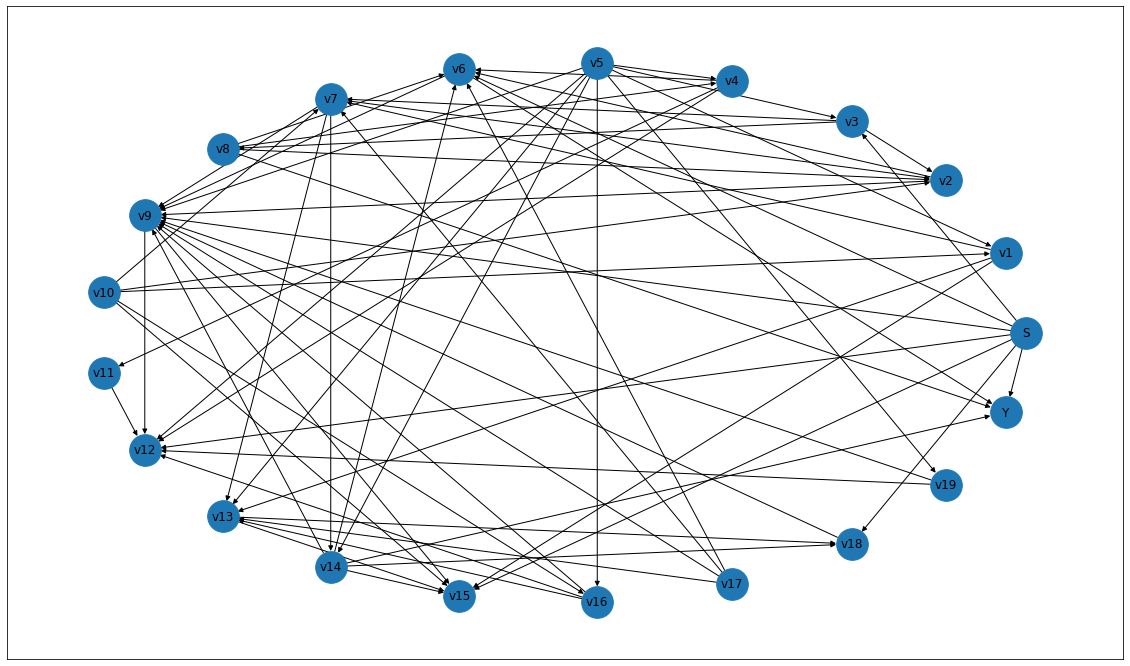

In [13]:
import matplotlib.pyplot as plt
G = nx.DiGraph(dataset.W_all)
# G.add_edges_from(
#     [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
#      ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 1) for node in G.nodes()]
nodesdic={0:'S',1:'v1',2:'v2',3:'v3',4:'v4',5:'v5',6:'v6',7:'v7',8:'v8',9:'v9',10:'v10',11:'v11',12:'v12',
          13:'v13',14:'v14',15:'v15',16:'v16',17:'v17',18:'v18',19:'v19',20:'Y'}

plt.figure(figsize=(20,12))
nx.draw_networkx(G, cmap = plt.get_cmap('jet'), labels=nodesdic, node_size=1000, pos=nx.circular_layout(G))
plt.show()